In [2]:
!pip install yfinance pandas numpy matplotlib --quiet

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [4]:
TICKERS = ["XOM", "CVX"]
END_DATE = datetime.today()
START_DATE = END_DATE - timedelta(days=90)

adj_close = pd.DataFrame()

for ticker in TICKERS:
    data = yf.download(ticker, start=START_DATE, end=END_DATE)
    if 'Adj Close' in data.columns:
        adj_close[ticker] = data['Adj Close']
    else:
        # fallback: take 4th column (usually Adjusted Close)
        adj_close[ticker] = data.iloc[:, 3]

# Compute next-day returns
returns = adj_close.pct_change().shift(-1)

C:\Users\hanwa\AppData\Local\Temp\ipykernel_35568\2039111896.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=START_DATE, end=END_DATE)
[*********************100%***********************]  1 of 1 completed
C:\Users\hanwa\AppData\Local\Temp\ipykernel_35568\2039111896.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=START_DATE, end=END_DATE)
[*********************100%***********************]  1 of 1 completed


In [5]:
np.random.seed(42)
sentiment = pd.DataFrame({
    "Date": returns.index,
    "XOM": np.random.uniform(-1,1,len(returns)),
    "CVX": np.random.uniform(-1,1,len(returns))
})

# Melt to long format
sentiment = sentiment.melt(id_vars='Date', var_name='Ticker', value_name='Sentiment')

In [6]:
returns_long = returns.stack().reset_index()
returns_long.columns = ["Date", "Ticker", "NextReturn"]

df = pd.merge(sentiment, returns_long, on=["Date","Ticker"])

In [7]:
df['Rank'] = df.groupby('Date')['Sentiment'].rank(ascending=False)
df['Position'] = df.groupby('Date')['Rank'].transform(lambda x: np.where(x==1,1,-1))
df['P&L'] = df['Position'] * df['NextReturn']

# Portfolio-level cumulative return
portfolio = df.groupby('Date')['P&L'].mean().cumsum().reset_index()
portfolio.rename(columns={'P&L':'CumulativeReturn'}, inplace=True)

# Individual stock cumulative returns
individual = df.groupby(['Date','Ticker'])['P&L'].sum().unstack().cumsum()

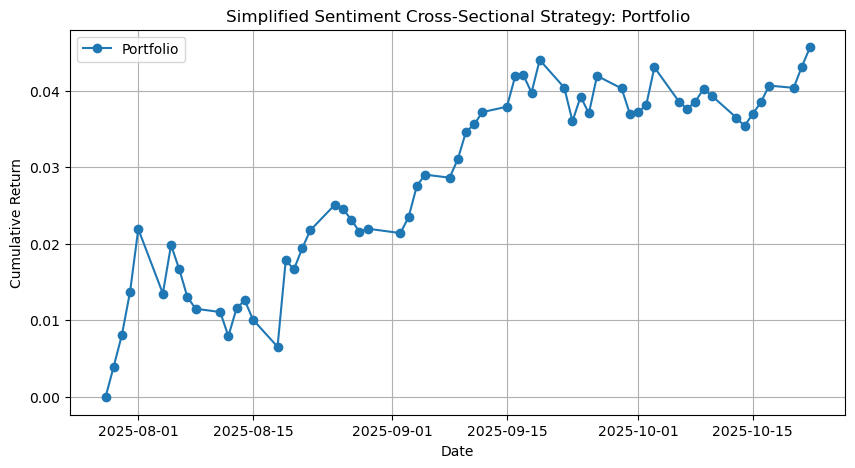

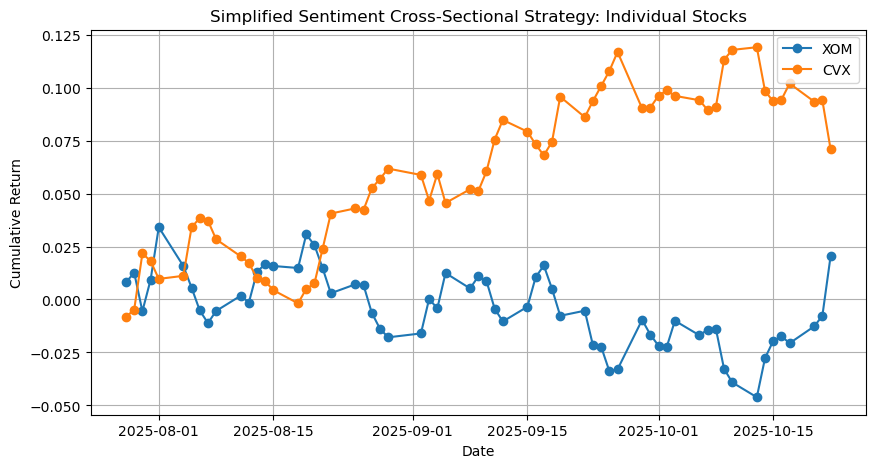

In [8]:
plt.figure(figsize=(10,5))
plt.plot(portfolio['Date'], portfolio['CumulativeReturn'], marker='o', label='Portfolio')
plt.title('Simplified Sentiment Cross-Sectional Strategy: Portfolio')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.legend()
plt.show()

# Plot individual stocks
plt.figure(figsize=(10,5))
for ticker in TICKERS:
    plt.plot(individual.index, individual[ticker], marker='o', label=ticker)
plt.title('Simplified Sentiment Cross-Sectional Strategy: Individual Stocks')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.legend()
plt.show()